# Intro:

## Business Problem: Predicting Water Wells In Need Of Repair For The Government Of Tanzania

## Stakeholder: The Ministry Of Water in Tanzania

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
df_train_target = pd.read_csv('./Data/training_set_labels.csv')
df_train_data = pd.read_csv('./Data/training_set_values.csv')

# Collapsing The Target Categories

The goal is to predict wells that require repair.

The target variable is `status_group` which has three categories:

- `functional`
- `functional needs repair`
- `non functional`

I will collapse the categories `functional needs repair` and `non functional` into one category `needs repair` to create a binary target variable.

In [30]:
# Look at df_train_target
df_train_target['status_group'].value_counts()



functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [31]:
# Change the name of the status_group in df_train_target 'functional needs repair' to 'repair'
# Also change the name of 'non functional' to non-functional
df_train_target['status_group'] = df_train_target['status_group'].replace('functional needs repair', 'repair')
df_train_target['status_group'] = df_train_target['status_group'].replace('non functional', 'repair')

# Check
df_train_target['status_group'].value_counts()

functional    32259
repair        27141
Name: status_group, dtype: int64

In [32]:
# encode status_group as 0, 1
df_train_target['status_group'] = df_train_target['status_group'].astype('category')
df_train_target['status_group'] = df_train_target['status_group'].cat.codes

# Check
df_train_target['status_group'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: status_group, dtype: float64

So now I have collapsed the target categories, and I have encoded the target variable as a binary variable.

Also note that the target variable is not imbalanced.

# Pipelines:

Time to set up some pipelines.

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

### Creating The pipelines

In [34]:
subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Creating the column transformer

In [35]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

### Dummy Model Pipeline:

In [36]:
dummy_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

### Logreg model pipeline

In [37]:
logreg_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('fsm', LogisticRegression(max_iter=1000))
])

### Now let's put in the data

# Test, Train, And Validation Split:

I will split the data into three sets:

- train 15%
- validation 15%
- test 70%

In [38]:
# Perform a 15-15-70 split on the data
from sklearn.model_selection import train_test_split

X = df_train_data
y = df_train_target['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

# Now split again to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

# Check the shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)



(35343, 40)
(6237, 40)
(17820, 40)


### Dummy Model:

In [39]:
# apply the dummy model pipeline to the data
dummy_model_pipe.fit(X_train, y_train)

# Check the score
dummy_model_pipe.score(X_train, y_train)

0.54344566109272

In [42]:
# check dummy model metrics
y_pred = dummy_model_pipe.predict(X_train)
print('Accuracy Score: ', accuracy_score(y_train, y_pred))
print('Precision Score: ', precision_score(y_train, y_pred))
print('Recall Score: ', recall_score(y_train, y_pred))
print('F1 Score: ', f1_score(y_train, y_pred))

# Check the score on the validation set
dummy_model_pipe.score(X_val, y_val)

# check dummy model metrics
y_pred = dummy_model_pipe.predict(X_val)
print('Accuracy Score: ', accuracy_score(y_val, y_pred))
print('Precision Score: ', precision_score(y_val, y_pred))
print('Recall Score: ', recall_score(y_val, y_pred))
print('F1 Score: ', f1_score(y_val, y_pred))

# Check the score on the test set
dummy_model_pipe.score(X_test, y_test)

Accuracy Score:  0.54344566109272
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0


c:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score:  0.5385602052268719
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0


c:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.543939393939394

### Logreg Model:

In [40]:
# apply the logreg pipeline to the data
logreg_model_pipe.fit(X_train, y_train)

0.9208329796565091

Logistic Regression Model
Training Accuracy:  0.9208329796565091
Validation Accuracy:  0.8031104697771364
Test Accuracy:  0.8042648709315376
Training Recall:  0.8818790282597918
Validation Recall:  0.7383599722029187
Test Recall:  0.7392641811246462
Training Precision:  0.94101309350615
Validation Precision:  0.8173076923076923
Test Precision:  0.8144232072658262
Training F1:  0.9104869153496705
Validation F1:  0.7758305951077035
Test F1:  0.7750257997936016


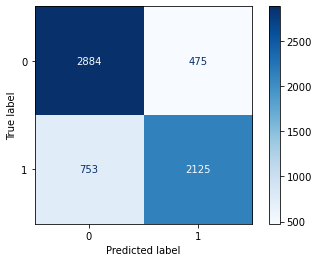

In [41]:
# Check model metrics
print('Logistic Regression Model')
print('Training Accuracy: ', logreg_model_pipe.score(X_train, y_train))
print('Validation Accuracy: ', logreg_model_pipe.score(X_val, y_val))
print('Test Accuracy: ', logreg_model_pipe.score(X_test, y_test))
print('Training Recall: ', recall_score(y_train, logreg_model_pipe.predict(X_train)))
print('Validation Recall: ', recall_score(y_val, logreg_model_pipe.predict(X_val)))
print('Test Recall: ', recall_score(y_test, logreg_model_pipe.predict(X_test)))
print('Training Precision: ', precision_score(y_train, logreg_model_pipe.predict(X_train)))
print('Validation Precision: ', precision_score(y_val, logreg_model_pipe.predict(X_val)))
print('Test Precision: ', precision_score(y_test, logreg_model_pipe.predict(X_test)))
print('Training F1: ', f1_score(y_train, logreg_model_pipe.predict(X_train)))
print('Validation F1: ', f1_score(y_val, logreg_model_pipe.predict(X_val)))
print('Test F1: ', f1_score(y_test, logreg_model_pipe.predict(X_test)))

# Check the confusion matrix
plot_confusion_matrix(logreg_model_pipe, X_val, y_val, cmap='Blues', values_format='d');